In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets.data_handler import DataHandler


2022-09-22 11:09:03.414090: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-22 11:09:03.524803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 11:09:03.524936: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [2]:
data_handler = DataHandler()

#### MNIST
# Load the data and split it between train and test sets
(x_train, y_train), (x_id, y_id) = data_handler.load("mnist")

#### Fashion MNIST
# Load the data and split it between train and test sets
_ , (x_ood, y_ood) = data_handler.load("fashion_mnist")


x, labels = data_handler.merge(x_id, x_ood)


In [3]:


model = get_model("../saved_models/mnist_model")

2022-09-22 11:09:18.958879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-22 11:09:18.959939: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 11:09:18.960606: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-09-22 11:09:18.973485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Maximum Logit Score
(A good classifier is all you need ?)

Example of method that does not need ID data to compute statistics to compare against

In [4]:

%autoreload 2
oodmodel = MLS(output_activations=["linear"])
oodmodel.fit(model)
scores = oodmodel.score(x)

Score visualization

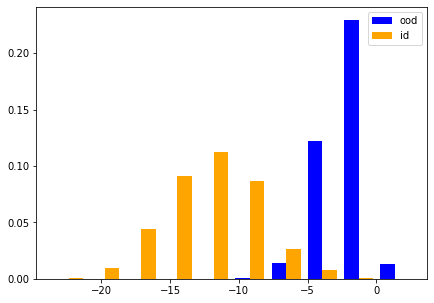

In [5]:
plt.figure(figsize=(7,5))

scores_id, scores_ood = oodmodel.score([x_id, x_ood])
plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

Sanity check to test the `__call__` method

In [6]:
oodmodel.threshold = -5
isooddata = oodmodel.isood(inputs=x_ood)
isooddata2 = oodmodel(x_ood)
print(np.sum(isooddata - isooddata2))
print(np.sum(isooddata)/x_ood.shape[0])

0.0
0.949


## Deep KNN
Example of method that needs ID data to compute statistics to compare against

In [7]:
x, labels = data_handler.merge(x_id[:1000], x_ood[:1000])

In [8]:
%autoreload 2
oodmodel = DKNN()
oodmodel.fit(model, x_train[:10000])
scores = oodmodel.score(x)

Score visualization

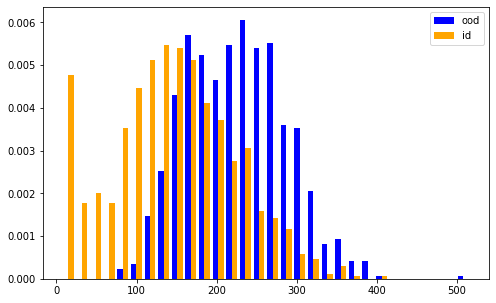

In [9]:
plt.figure(figsize=(8,5))

scores_id, scores_ood = oodmodel.score([x_id[:1000], x_ood[:1000]])
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()